In [7]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pickle

**NOTE:** This project is not classifying whether if the parking space has a car in it or not. This project already has the images labeled into empty or not empty.
What this project will do is it will learn to predict whether an image is of an "empty" parking space or a "not_empty" parking space based on the pixel patterns it sees during training. The code doesn't perform the classification of the images, it just reads the image data and prepares it for training.

Loading and prepare data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
input_dir = "/content/drive/My Drive/clf-data.zip"  # define the path to the zip file in your drive
extract_path = "/content/data" #set the extraction path
data_path = os.path.join(extract_path, "clf-data") #joins the extract path and folder name (clf-data)

with zipfile.ZipFile(input_dir, 'r') as zip_ref:  #open zip file in read mode
    zip_ref.extractall(extract_path) #extracts all the contents of the zip file

In [10]:
categories = ['empty', 'not_empty'] #define list categories with two target variables

In [11]:
data = [] #create empty list to store data
labels = []

for category in categories:  #for loop to iterate each category in categories
    category_path = os.path.join(data_path, category) #create a path for foldercorresponding to current category
    label = categories.index(category) #assign index to categories, emptty will be 0 and no empty will be 1

    for file in os.listdir(category_path): #loop through all the images in empty and not empty folder
        img_path = os.path.join(category_path, file) #creates full path to each image by join
        try:
            img = imread(img_path) #try to read image
            img = resize(img, (15, 15)) #resize image 15x15 pixels
            data.append(img.flatten()) #flattens image to 1d array and appends it to the data list
            labels.append(label) #appends the corresponding label
        except Exception as e: #error handling
            print(f"Error loading {img_path}: {e}")

print("Final Length of data:", len(data))
print("Final Length of labels:", len(labels))


Final Length of data: 6090
Final Length of labels: 6090


Next we need to split the data into training and testing

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, stratify = labels) #stratify ensures that the split respects the original class distribution, preventing any class imbalance issues in the training and testing sets.

Train the classifier

In [13]:
classifier = SVC() # creating a new instance of SVC(support vector classifier)

We are gonna train many different image classifiers, for each combination of gamma and C

In [14]:
parameters = [{'gamma':[0.01, 0.001, 0.0001], 'C':[1,10,100,1000] }] # parameters obj - with 2 dictionaries gamma and C
#The parameters object defines a grid of possible values for the gamma and C hyperparameters of the SVC model.

In [15]:
grid_search = GridSearchCV(classifier, parameters) #is creating an instance of GridSearchCV, which is used for hyperparameter tuning by performing an exhaustive search over a specified parameter grid.

In [16]:
grid_search.fit(x_train, y_train) #the actual training of the model occurs

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}])

Test the performance

In [17]:
best_estimator = grid_search.best_estimator_ #retrieves the best model from the grid search

In [18]:
y_prediction = best_estimator.predict(x_test) #makes prediction on the test set using the best model found

In [19]:
score = accuracy_score(y_prediction, y_test) #calculate the accuracy of the model

In [20]:
print('{}% of samples of correctly classified'.format(str(score * 100))) #get the percentage not just a decimal

100.0% of samples of correctly classified


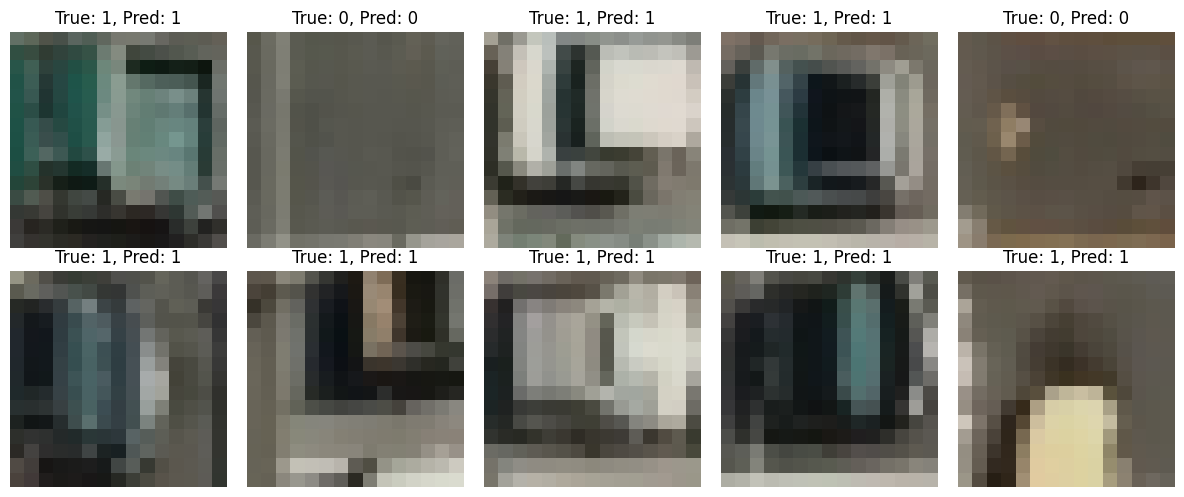

In [21]:
#Let us visualize some random images from our model
num_samples = 10
random_indices = random.sample(range(len(x_test)), num_samples)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, idx in enumerate(random_indices):
    img = x_test[idx].reshape(15, 15, 3)  # Reshape to 15x15 RGB image
    true_label = y_test[idx]  # Actual label
    pred_label = y_prediction[idx]  # Predicted label

    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(f"True: {true_label}, Pred: {pred_label}")
    ax.axis("off")

plt.tight_layout()
plt.show()


From the 10 random samples we retrieved, we can see that True Label and Predicted Label are a match. True label is what the image is, and Predicted label is what the model thinks the true label is based on the pixel patterns it learned during training.

In [22]:
#This allows you to reload the model later without retraining.
pickle.dump(best_estimator, open('./model.p', 'wb'))

In [23]:
#to open the model on a different workbook or project
#import pickle

# Load the model
#loaded_model = pickle.load(open('./model.p', 'rb'))

# Use the model for predictions
#y_pred = loaded_model.predict(x_test)
